# Compressed Sensing: Application à l'IRM
    GARNIER Rémy (M2 StatML), NGUYEN Dinh-Phong (M2 Data Science)

In [27]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from IPython import display
warnings.filterwarnings('ignore')
%matplotlib inline

## Incohérence

On explore l'importance de l'incohérence des vecteurs de mesure. Générons un vecteur $x$ de longueur 100 avec 5 coefficients non-nuls positionnés aléatoirement, représentant un signal quelconque 5-sparse.

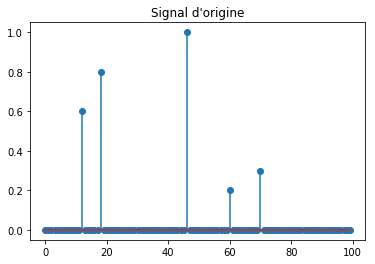

In [2]:
x = np.array([0.2, 0.3, 0.6, 0.8, 1.] + [0] * 95)
np.random.shuffle(x)
plt.stem(x)
plt.title('Signal d\'origine');

Prenons la transformation de Fourier discrète de ce vecteur, $X = Fx$, où $F$ représente la matrice de Vandermonde-Fourier:

In [3]:
X = np.fft.fft(x)

L'objectif principal du compressed sensing est de pouvoir reconstruire le signal d'origine à partir d'une "information incomplète" (nombre de mesures limité) sur celui-ci. Il est en général impossible de reconstruire $x$ uniquement à partir des coefficients de Fourier car la transformée de Fourier est une bijection de $\mathbb{C}^N$. Néanmoins, si l'on sait que le signal d'origine $x$ est $s$-sparse, on se trouve bien dans le cadre du compressed sensing.

Prenons alors un sous-échantillon $X_u = F_u x$ de $X$, où $F_u$ est une matrice de Vandermonde-Fourier évaluée sur seulement une partie du domaine de fréquences. Nous allons comparer deux cas de sous-échantillonage dans le domaine de Fourier:

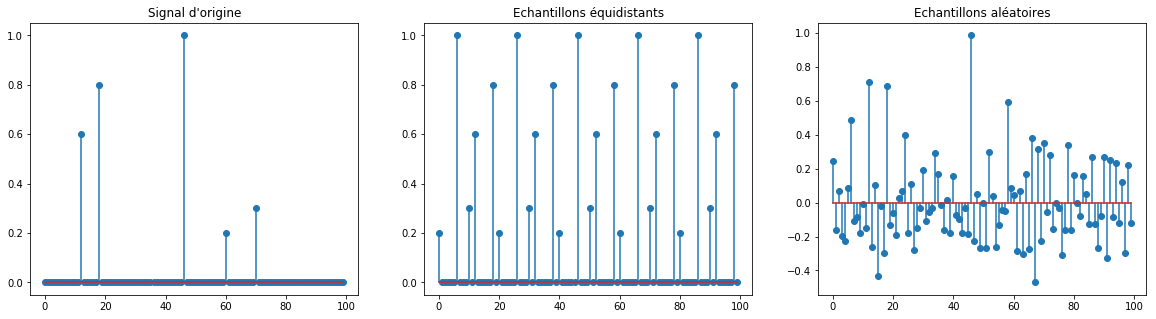

In [4]:
Xu = np.zeros(100, dtype='complex')
Xu[::5] = X[::5]

Xr = np.zeros(100, dtype='complex')
sample_idx = np.random.choice(100, 20)
Xr[sample_idx] = X[sample_idx]

# Transformée inverse
xu = np.fft.ifft(Xu) * 5
xr = np.fft.ifft(Xr) * 5

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].stem(x)
ax[0].set_title('Signal d\'origine')
ax[1].stem(xu)
ax[1].set_title('Echantillons équidistants')
ax[2].stem(xr)
ax[2].set_title('Echantillons aléatoires');

## Reconstruction

In [5]:
def SoftThresh(y, t):
    x_hat = np.sign(y) * np.maximum(np.abs(y)-t, 0)
    return x_hat

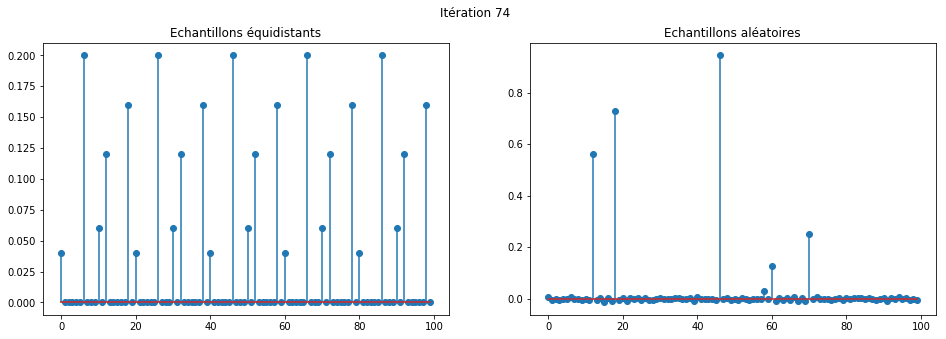

In [26]:
l = 0.01
n_iter = 75

Y1 = Xu
Y2 = Xr
Xi1 = Y1
Xi2 = Y2

for i in range(n_iter):
    xi1 = np.fft.ifft(Xi1)
    xi1_st = SoftThresh(xi1.real, l)
    Xi1 = np.fft.fft(xi1_st)
    Xi1 = Xi1 * (Y1==0) + Y1
    
    xi2 = np.fft.ifft(Xi2)
    xi2_st = SoftThresh(xi2.real, l)
    Xi2 = np.fft.fft(xi2_st)
    Xi2 = Xi2 * (Y2==0) + Y2
    
    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].stem(xi1.real)
    ax[0].set_title('Echantillons équidistants')
    ax[1].stem(xi2.real)
    ax[1].set_title('Echantillons aléatoires')
    plt.suptitle('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Application à l'IRM

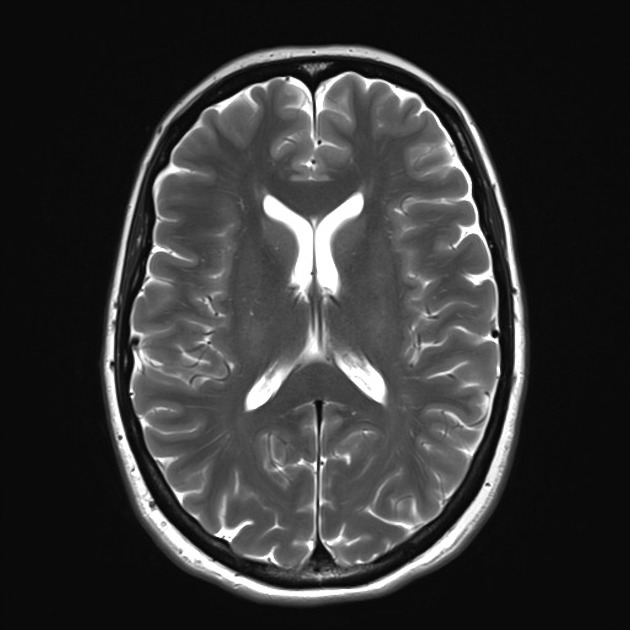

In [34]:
brain = Image.open("brain_mri.jpeg")
brain

In [101]:
brain_array = np.array(brain)
brain_fourier = np.fft.fft2(brain_array)
brain_fourier_shift = np.fft.fftshift(brain_fourier)
brain_fourier_powerspect = np.abs(brain_fourier_shift) ** 2

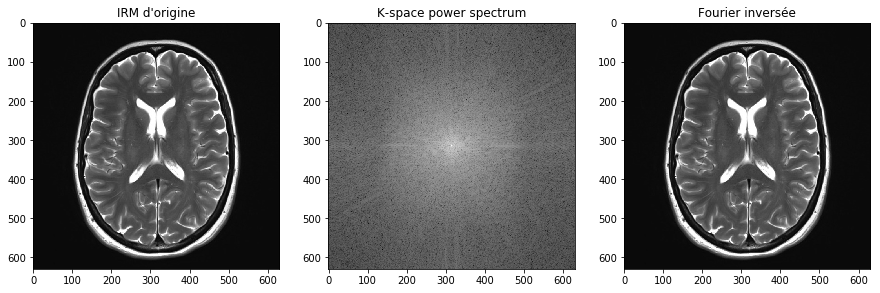

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(brain)
ax[0].set_title('IRM d\'origine')
ax[1].imshow(np.log10(brain_fourier_powerspect.real), cmap='gray')
ax[1].set_title('K-space power spectrum')
ax[2].imshow(np.fft.ifft2(brain_fourier).real, cmap='gray')
ax[2].set_title('Fourier inversée');

## Brouillon

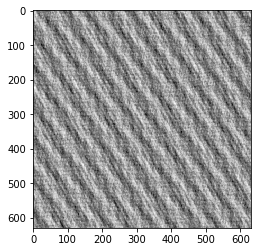

In [125]:
brain_under = np.zeros(brain_fourier.shape, dtype='complex')
sample_x = np.random.choice(brain_fourier.shape[0], int(brain_fourier.shape[0] / 1))
sample_y = np.random.choice(brain_fourier.shape[0], int(brain_fourier.shape[0] / 1))
brain_under[sample_x, sample_y] = brain_fourier[sample_x, sample_y]

brain_rec = np.fft.ifft2(brain_under) * 1

plt.imshow(brain_rec.real, cmap='Greys');

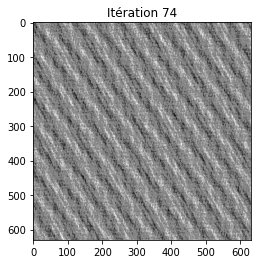

In [126]:
l = 0.01
n_iter = 75

Y = brain_under
Xi = Y

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, l)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y
    
    plt.close()
    plt.imshow(xi.real, cmap='gray')
    plt.title('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)